In [71]:
import numba, numpy as np
from scipy import interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
from scipy.spatial.distance import pdist
# Linear Approximator related functions
import warnings
warnings.filterwarnings('ignore')

#Idea: 
    # Peicewise spline?  Spline of splines?
    # Figure out how to do this with the spline concatenation 
    # 


# Spline value calculating function, given params and "x"
#@numba.njit(cache = True, fastmath = True, inline = 'always')
def func_linear(x, ix, x0, y0, k):
    return (x - x0[ix]) * k[ix] + y0[ix]
    
# Compute piece-wise linear function for "x" out of sorted "x0" points
#@numba.njit([f'f{ii}[:](f{ii}[:], f{ii}[:], f{ii}[:], f{ii}[:], f{ii}[:], f{ii}[:])' for ii in (4, 8)],
 #   cache = True, fastmath = True, inline = 'always')
def piece_wise_linear(x, x0, y0, k, dummy0, dummy1):
    xsh = x.shape
    x = x.ravel()
    ix = np.searchsorted(x0[1 : -1], x)
    y = func_linear(x, ix, x0, y0, k)
    y = y.reshape(xsh)
    return y
    
# Spline Approximator related functions
    
# Solves linear system given by Tridiagonal Matrix
# Helper for calculating cubic splines
#@numba.njit(cache = True, fastmath = True, inline = 'always')
def tri_diag_solve(A, B, C, F):
    n = B.size
    assert A.ndim == B.ndim == C.ndim == F.ndim == 1 and (
        A.size == B.size == C.size == F.size == n
    ) #, (A.shape, B.shape, C.shape, F.shape)
    Bs, Fs = np.zeros_like(B), np.zeros_like(F)
    Bs[0], Fs[0] = B[0], F[0]
    for i in range(1, n):
        Bs[i] = B[i] - A[i] / Bs[i - 1] * C[i - 1]
        Fs[i] = F[i] - A[i] / Bs[i - 1] * Fs[i - 1]
    x = np.zeros_like(B)
    x[-1] = Fs[-1] / Bs[-1]
    for i in range(n - 2, -1, -1):
        x[i] = (Fs[i] - C[i] * x[i + 1]) / Bs[i]
    return x
    
# Calculate cubic spline params
#@numba.njit(cache = True, fastmath = True, inline = 'always')
def calc_spline_params(x, y):
    a = y
    h = np.diff(x)
    c = np.concatenate((np.zeros((1,), dtype = y.dtype),
        np.append(tri_diag_solve(h[:-1], (h[:-1] + h[1:]) * 2, h[1:],
        ((a[2:] - a[1:-1]) / h[1:] -
         (a[1:-1] - a[:-2]) / h[:-1]) * 3), 0)))
    d = np.diff(c) / (3 * h)
    b = (a[1:] - a[:-1]) / h + (2 * c[1:] + c[:-1]) / 3 * h
    return a[1:], b, c[1:], d
    
# Spline value calculating function, given params and "x"
#@numba.njit(cache = True, fastmath = True, inline = 'always')
def func_spline(x, ix, x0, a, b, c, d):
    dx = x - x0[1:][ix]
    return a[ix] + (b[ix] + (c[ix] + d[ix] * dx) * dx) * dx
    
# Compute piece-wise spline function for "x" out of sorted "x0" points
#@numba.njit([f'f{ii}[:](f{ii}[:], f{ii}[:], f{ii}[:], f{ii}[:], f{ii}[:], f{ii}[:])' for ii in (4, 8)],
#    cache = True, fastmath = True, inline = 'always')
def piece_wise_spline(x, x0, a, b, c, d):
    xsh = x.shape
    x = x.ravel()
    ix = np.searchsorted(x0[1 : -1], x)
    y = func_spline(x, ix, x0, a, b, c, d)
    y = y.reshape(xsh)
    return y
    
# Appximates function given by (x0, y0) by piece-wise spline or linear
def approx_func(x0, y0, t = 'spline'): # t is spline/linear
    assert x0.ndim == 1 and y0.ndim == 1 and x0.size == y0.size#, (x0.shape, y0.shape)
    n = x0.size - 1
    if t == 'linear':
        k = np.diff(y0) / np.diff(x0)
        return piece_wise_linear, (x0, y0, k, np.zeros((0,), dtype = y0.dtype), np.zeros((0,), dtype = y0.dtype))
    elif t == 'spline':
        a, b, c, d = calc_spline_params(x0, y0)
        return piece_wise_spline, (x0, a, b, c, d)
    else:
        assert False, t
        
def get_first_point(x, y, d, d0, is_spline, strict, aerr, rerr, a0, a1, a2, a3, a4):
    t0 = np.zeros((1,), dtype = y.dtype)
    i, x0, y0 = 0, d0[0], d0[1]
    found = False
    dm, xm, ym = d, x0, y0
    while not found:
        if i + 1 >= x.size:
            break

        ie = min(i + 1 + np.searchsorted(x[i + 1:], x0 + d), x.size - 1)
        print("TEST ie", ie,i, type(ie))
        if(type(ie) == np.ndarray):
            print("Convert")
            ie = ie[0]
        for ie in range(i + 1 if strict else ie, ie + 1):
            xl = max(x0, x[ie - 1 if strict else i])
            xr = max(x0, x[ie])
            # Do binary search to find next point
            for ii in range(1000):
                if xr - xl <= aerr:
                    break # Already very small delta X interval
                xm = (xl + xr) / 2
                t0[0] = xm
                if is_spline:
                    ym = piece_wise_spline(t0, a0, a1, a2, a3, a4)[0]
                else:
                    ym = piece_wise_linear(t0, a0, a1, a2, a3, a4)[0]
                
                # Compute Euclidian distance
                dx_, dy_ = xm - x0, ym - y0
                dm = np.sqrt(dx_ * dx_ + dy_ * dy_)
#                 print(dm, xl, xr)

                if -rerr <= dm / d - 1. <= rerr:
                    found = True
                    break # We got d with enough precision
                if dm >= d:
                    xr = xm
                else:
                    xl = xm
            else:
                assert False # To many iterations
            if -rerr <= dm / d - 1. <= rerr:
                break # Next point found
        else:
            break # No next point found, we're finished
        i = np.searchsorted(x, xm) - 1
    return [xm,ym]
    

# Main function that computes Euclidian Equi-Distant points based on approximation function
#@numba.njit(
#    [f'f{ii}[:, :](f{ii}[:], f{ii}[:], f{ii}, b1, b1, f{ii}, f{ii}, f{ii}[:], f{ii}[:], f{ii}[:], f{ii}[:], f{ii}[:])' for ii in (4, 8)],
#    cache = True, fastmath = True)
def _resample_inner(x, y, d, d0, is_spline, strict, aerr, rerr, a0, a1, a2, a3, a4,neg=False):
    rs, r = 0, np.zeros((1 << 10, 2), dtype = y.dtype)
    t0 = np.zeros((1,), dtype = y.dtype)
    #print(i, x0, y0, np.sin(x0))
    finalx0, finaly0 = get_first_point(x, y,d, d0, is_spline, strict, aerr, rerr, a0, a1, a2, a3, a4)
    print("First Point", finalx0, finaly0)
    if(neg):
        finalx0 = -finalx0
    dx_, dy_ = finalx0 - d0[0], finaly0 - d0[1]
    dm = np.sqrt(dx_ * dx_ + dy_ * dy_)
#     print("Dist", finalx0, finaly0, d0[0], d0[1], dm)
#     print(finalx0, finaly0)
    i, x0, y0, dm  = 1, finalx0, finaly0, 1000
    while True:
        if rs >= r.size:
            r = np.concatenate((r, np.zeros(r.shape, dtype = r.dtype))) # Grow array
        r[rs, 0] = x0
        r[rs, 1] = y0
        rs += 1
        if i >= x.size:
            break
        ie = min(i + 1 + np.searchsorted(x[i + 1:], x0 + d), x.size - 1)
        for ie in range(i + 1 if strict else ie, ie + 1):
            xl = max(x0, x[ie - 1 if strict else i])
            xr = max(x0, x[ie])
            # Do binary search to find next point
            for ii in range(1000):
                if xr - xl <= aerr:
                    break # Already very small delta X interval
                xm = (xl + xr) / 2
                t0[0] = xm
                if is_spline:
                    ym = piece_wise_spline(t0, a0, a1, a2, a3, a4)[0]
                else:
                    ym = piece_wise_linear(t0, a0, a1, a2, a3, a4)[0]
                
                # Compute Euclidian distance
                dx_, dy_ = xm - x0, ym - y0
                dm = np.sqrt(dx_ * dx_ + dy_ * dy_)

                if -rerr <= dm / d - 1. <= rerr:
                    break # We got d with enough precision
                if dm >= d:
                    xr = xm
                else:
                    xl = xm
            else:
                assert False # To many iterations
            if -rerr <= dm / d - 1. <= rerr:
                break # Next point found
        else:
            break # No next point found, we're finished
        i = np.searchsorted(x, xm) - 1
        #print('_0', i, x0, y0, np.sin(x0), dist(x0, xm, y0, ym), dist(x0, xm, np.sin(x0), np.sin(xm)))
        x0, y0 = xm, ym
        #print('_1', i, x0, y0, np.sin(x0), dm)
    return finalx0, finaly0, r[:rs]
    
# Resamples (x, y) points using given approximation function type
# so that euclidian distance between each resampled points equals to "d".
# If strict = True then strictly closest (by X) next point at distance "d"
# is chosen, which can imply more computations, when strict = False then
# any found point with distance "d" is taken as next.
def resample_euclid_equidist(
    x, y, d, *, d0=[],
    aerr = 2 ** -21, rerr = 2 ** -9, approx = 'spline',
    return_approx = False, strict = True, neg=False
):
    if(len(d0) < 2):
        d0 = [x[0],y[0]]
    assert d > 0, d
    dtype = np.dtype(y.dtype).type
    x, y, d, aerr, rerr = [dtype(e) for e in [x, y, d, aerr, rerr]]
    ixs = np.argsort(x)
    x, y = x[ixs], y[ixs]
    f, fargs = approx_func(x, y, approx)
    tot = _resample_inner(x, y, d,d0, approx == 'spline', strict, aerr, rerr, *fargs, neg=neg)
    x0, y0, r = tot
    return x0, y0, (r[:, 0], r[:, 1]) + ((), (lambda x: f(x, *fargs),))[return_approx]






def test():
    import matplotlib.pyplot as plt, numpy as np, time
    np.random.seed(0)
    # Input
    n = 50
    x = np.sort(np.random.uniform(0., 10 * np.pi, (n,)))
    y = np.sin(x) * 5 + np.sin(1 + 2.5 * x) * 3 + np.sin(2 + 0.5 * x) * 2
    # Visualize
    for isl, sl in enumerate(['spline', 'linear']):
        # Compute resampled points
        for i in range(3):
            tb = time.time()
            x0, y0, [xa, ya, fa] = resample_euclid_equidist(x, y, 1, approx = sl, return_approx = True)
            print(sl, 'try', i, 'run time', round(time.time() - tb, 4), 'sec', flush = True)
        # Compute spline/linear approx points
        fax = np.linspace(x[0], x[-1], 1000)
        fay = fa(fax)
        # Plotting
        plt.rcParams['figure.figsize'] = (7.2, 4.5)
        for ci, (cx, cy, fn) in enumerate([
            (x, y, 'original'), (fax, fay, f'approx_{sl}'), (xa, ya, 'euclid_euqidist'),
        ]):
            p, = plt.plot(cx, cy)
            p.set_label(fn)
            if ci >= 2:
                plt.scatter(cx, cy, marker = '.', color = p.get_color())
                if False:
                    # Show distances
                    def dist(x0, x1, y0, y1):
                        # Compute Euclidian distance
                        dx, dy = x1 - x0, y1 - y0
                        return np.sqrt(dx * dx + dy * dy)
                    for i in range(cx.size - 1):
                        plt.annotate(
                            round(dist(cx[i], cx[i + 1], cy[i], cy[i + 1]), 2),
                            (cx[i], cy[i]), fontsize = 'xx-small',
                        )
        plt.gca().set_aspect('equal', adjustable = 'box')
        plt.legend()
        plt.show()
        plt.clf()
        print(x[0],y[0],xa[0],ya[0])



TEST ie 2 0 <class 'int'>
First Point 0.888638132214379 5.1797855214338835
spline try 0 run time 0.0351 sec
TEST ie 2 0 <class 'int'>
First Point 0.888638132214379 5.1797855214338835
spline try 1 run time 0.0322 sec
TEST ie 2 0 <class 'int'>
First Point 0.888638132214379 5.1797855214338835
spline try 2 run time 0.0305 sec


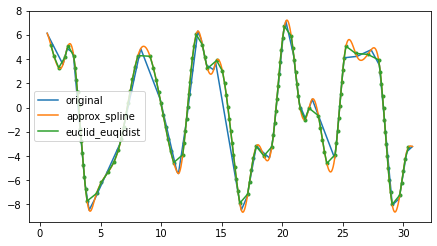

0.590298990132716 6.134075601968668 0.888638132214379 5.1797855214338835
TEST ie 2 0 <class 'int'>
First Point 1.031630426036258 5.2374061221703245
linear try 0 run time 0.0256 sec
TEST ie 2 0 <class 'int'>
First Point 1.031630426036258 5.2374061221703245
linear try 1 run time 0.0275 sec
TEST ie 2 0 <class 'int'>
First Point 1.031630426036258 5.2374061221703245
linear try 2 run time 0.0275 sec


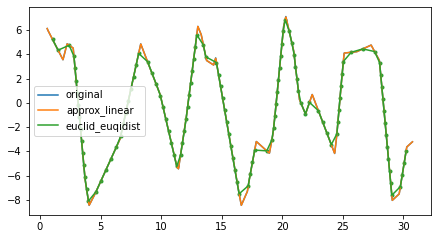

0.590298990132716 6.134075601968668 1.031630426036258 5.2374061221703245


<Figure size 518.4x324 with 0 Axes>

In [68]:
test()
#0.590298990132716 6.134075601968668

In [3]:
f = pd.read_csv("../../ants.txt", delimiter=',')

In [4]:
f1 = f[f['id']==1]
# f1=f1.sort_values(by=['x'])

In [5]:
f1.drop_duplicates(subset=['x'], inplace=True)

not f1["x"].is_unique

False

In [6]:
max(f1['x'])

2094.8920000000003

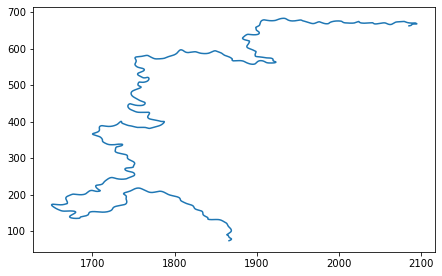

In [7]:
plt.plot(f1['x'],f1['y'])
# plt.scatter(f1['x'][0],f1['y'][0])

In [8]:
def get_next_subsection(a,b,c):
    newa = []
    newb = []
    newc = []
    neg = np.sign(a[0]-a[1])
    i = 0
    
    while(i < len(a)-1 and np.sign(a[i] - a[i+1]) == neg):
        newa.append(a[i])
        newb.append(b[i])
        newc.append(c[i])
        i+=1
    if(neg == 1):
        newa = [-x for x in newa]
#         newa.reverse()
#         newb.reverse()
#         newc.reverse()
    return newa,newb,newc,i,neg

TEST ie 12 0 <class 'numpy.int64'>
First Point 1915.3525625 574.3766880232033
4
TEST ie 18 0 <class 'int'>
First Point 1919.9589999999998 569.4965
1
TEST ie [33] 0 <class 'numpy.ndarray'>
Convert


TypeError: only integer scalar arrays can be converted to a scalar index

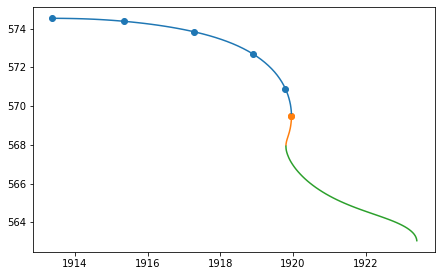

In [72]:
def get_spline(f1,d = 2, plot=False):
    j = 0
    xl = list(f1['x'])
    yl = list(f1['y'])
    tl = list(f1['t'])
    newx = []
    newy = []
    newt = []
#     plt.plot(xl, yl)
    offset = 0.1
    while(j < len(f1['x'])-1):
        xj, yj, tj, newj, neg = get_next_subsection(xl[j:],yl[j:],tl[j:])
        if(len(xj) > 2):
            g = interpolate.CubicSpline(xj, yj, bc_type='natural')
            gt = interpolate.CubicSpline(xj, tj, bc_type='natural')
            init_x = xj[0]
            if(neg == 1):
                pltx = [-x for x in xj]
                init_x = -xj[0]
                plt.plot(pltx, yj)
                if(len(newx)>1):
                    x0, y0, lists = resample_euclid_equidist(np.asarray(xj), np.asarray(yj), d, d0=[-newx[-1],newy[-1]], approx = 'spline', neg=True, return_approx = True)
                else:
                    x0, y0, lists = resample_euclid_equidist(np.asarray(xj), np.asarray(yj), d, d0=[-xj[0],yj[0]], approx = 'spline', neg=True, return_approx = True)
                xa, ya, fa =lists
                xa = [-x for x in xa]
            
            else:
                plt.plot(xj, yj)
                if(len(newx)>1):
                    x0, y0, lists = resample_euclid_equidist(np.asarray(xj), np.asarray(yj), d, d0=[newx[-1],newy[-1]], approx = 'spline', return_approx = True)
                else:
                    x0, y0, lists = resample_euclid_equidist(np.asarray(xj), np.asarray(yj), d, d0=[xj[0],yj[0]], approx = 'spline', return_approx = True)
            
                xa, ya, fa = lists
            
            t_new = g(xa)
            print(len(xa))
            
#             if(neg == 1):
#                 print(xa)
#                 xa = np.asarray([-x for x in xa])
                
            if(xa[0] != 0):
                dx_, dy_ = xl[j] - xa[0], yl[j] - ya[0]
                dm = np.sqrt(dx_ * dx_ + dy_ * dy_)
                offset =  d-dm
                                        
                xa = np.insert(xa, 0, init_x)
                ya = np.insert(ya,0, yj[0])

                newx.append(xa[1:])
                newy.append(ya[1:])
                newt.append(t_new[1:])
                if(plot):
                    plt.scatter(xa, ya)
            else:
                offset = 0.1
#             if(abs(offset)> d):
#                 print("ERROR, Offset too large")
        if(newj -1 != 0):
            j += newj-1
        else:
            j+=1
    newx = np.concatenate([x.ravel() for x in newx])
    newy = np.concatenate([x.ravel() for x in newy])
    newt = np.concatenate([x.ravel() for x in newt])
    return newx, newy, newt
x,y,t = get_spline(f1[2000:3000],plot=True)

In [37]:
arr = [[x[i],y[i]] for i in range(len(x))]
print(len(arr))


36


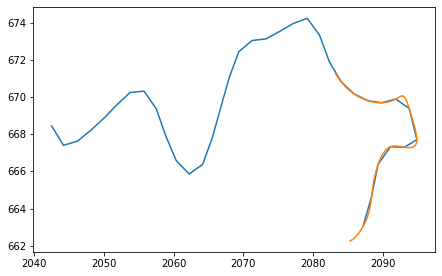

In [38]:
plt.plot(x,y)
plt.plot(f1['x'][0:200],f1['y'][0:200])

In [39]:
print(y)
print(f1['y'][100])

[663.04221572 664.62840167 666.39077138 667.33104066 667.30436624
 667.7121     669.39179312 669.90121112 669.70036654 669.80982595
 670.16936212 670.83489121 671.91004597 673.33336962 674.24770294
 673.97022652 673.54356271 673.13913565 673.05301586 672.44786191
 671.02629836 669.42195997 667.81804621 666.38134412 665.86386839
 666.58746011 667.91598946 669.37389322 670.32533091 670.25473597
 669.59197805 668.8688443  668.21330287 667.63060209 667.4086632
 668.45287884]
667.2844


In [40]:
d = []
for i in range(len(arr)-1):
    d.append(pdist([arr[i],arr[i+1]])[0])
d

[1.997842753216521,
 2.0023479399767434,
 1.9995018618459504,
 1.9990529733303541,
 1.8346316750529768,
 2.002910373139221,
 1.996974123238278,
 2.0016331497128226,
 1.9967212666539316,
 1.9984206371143052,
 1.9990677294004662,
 1.9992168474468937,
 1.997555418895749,
 2.000545128573244,
 2.0013907450340818,
 1.999642605664076,
 2.0003411419160075,
 2.0034767928750945,
 2.0007149457964544,
 1.9983651301519867,
 2.0012285523064817,
 2.0018975034492885,
 1.998661918559154,
 1.997203577307172,
 1.9966073069087686,
 2.000751421729187,
 1.996833395424538,
 1.9985094261479173,
 1.9999963019765203,
 1.9970561011100925,
 1.9999372040721146,
 2.002584484819667,
 2.0024081181463886,
 2.0027105400760274,
 2.001698366024171]

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 34.]),
 array([1.83463168, 1.85151619, 1.8684007 , 1.88528521, 1.90216972,
        1.91905423, 1.93593875, 1.95282326, 1.96970777, 1.98659228,
        2.00347679]),
 <BarContainer object of 10 artists>)

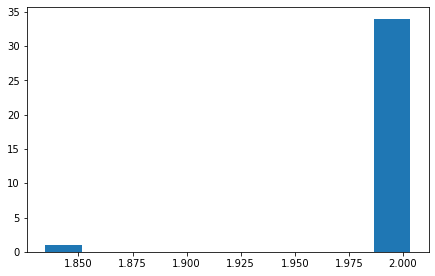

In [41]:
plt.hist(d)

In [422]:
print(len(f1))

7822


In [10]:
def get_spline(f1):
    j = 0
    xl = list(f1['x'])
    yl = list(f1['y'])
    tl = list(f1['t'])
    newx = []
    newy = []
    newt = []
    plt.plot(xl, yl)
    while(j < len(f1['x'])-1):
        xj, yj, tj, newj = get_next_subsection(xl[j:],yl[j:],tl[j:])
    #     print(np.shape(tj),np.shape(xj), np.shape(xl[j:]),np.shape(tl[j:]))
        if(len(xj) > 2):
            g = interpolate.CubicSpline(xj, yj, bc_type='natural')
            gt = interpolate.CubicSpline(xj, tj, bc_type='natural')
            x_new = np.arange(min(xj), max(xj), 2)
            y_new = g(x_new)
            t_new = g(x_new)
            newx.append(x_new)
            newy.append(y_new)
            newt.append(t_new)
            plt.plot(x_new, y_new)
        j += newj
    newx = np.concatenate([x.ravel() for x in newx])
    newy = np.concatenate([x.ravel() for x in newy])
    newt = np.concatenate([x.ravel() for x in newt])
    return newx, newy, newt

In [1]:
for i in np.unique(f['id']):
    f1 = f[f['id']==i]
    f1.drop_duplicates(subset=['x'], inplace=True)
    get_spline(f1)

NameError: name 'f' is not defined

In [45]:
newt.size

613